# CNTK 103: Part B - Feed Forward Network with MNIST

We assume that you have successfully completed CNTK 103 Part A.

In this tutorial we will train a fully connected network on MNIST data. This notebook provides the recipe using Python APIs. If you are looking for this example in Brainscript, please look [here](https://github.com/Microsoft/CNTK/tree/v2.0.beta2.0/Examples/Image/GettingStarted)

## Introduction

**Problem** (recap from the CNTK 101):

The MNIST data comprises of hand-written digits with little background noise.

<img src="http://3.bp.blogspot.com/_UpN7DfJA0j4/TJtUBWPk0SI/AAAAAAAAABY/oWPMtmqJn3k/s1600/mnist_originals.png", width=200, height=200>


**Goal**:
Our goal is to train a classifier that will identify the digits in the MNIST dataset. 

**Approach**:
The same 5 stages we have used in the previous tutorial are applicable: Data reading, Data preprocessing, Creating a model, Learning the model parameters and Evaluating (a.k.a. testing/prediction) the model. 
- Data reading: We will use the CNTK Text reader 
- Data preprocessing: Covered in part A (suggested extension section). 

Rest of the steps are kept identical to CNTK 102. 

In [4]:
# Import the relevant components
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import sys
import os

# from cntk import Trainer, cntk_device, StreamConfiguration, text_format_minibatch_source
from cntk import Trainer, StreamConfiguration, text_format_minibatch_source
from cntk.initializer import glorot_uniform
from cntk.learner import sgd
from cntk.ops import *

%matplotlib inline

## Data reading

In this section, we will read the data generated in CNTK 103 Part B.

In [5]:
#Ensure we always get the same amount of randomness
np.random.seed(0)

# Define the data dimensions
input_dim = 784
num_output_classes = 10

### Input and Labels

In this tutorial we are using the MNIST data you have downloaded using CNTK_103A_MNIST_DataLoader notebook. The dataset has 60,000 training images and 10,000 test images with each image being 28 x 28 pixels. Thus the number of features is equal to 784 (= 28 x 28 pixels), 1 per pixel. The variable `num_output_classes` is set to 10 corresponding to the number of digits (0-9) in the dataset.

In [6]:
# Ensure the training data is generated and available for this tutorial
train_file = "data/MNIST/Train-28x28_cntk_text.txt"

if os.path.isfile(train_file):
    path = train_file
else:
    print("Please generate the data by completing CNTK 103 Part A")

feature_stream_name = 'features'
labels_stream_name = 'labels'

mb_source = text_format_minibatch_source(path, [
    StreamConfiguration(feature_stream_name, input_dim),
    StreamConfiguration(labels_stream_name, num_output_classes)])
features_si = mb_source[feature_stream_name]
labels_si = mb_source[labels_stream_name]

print("Training data from file {0} successfully read.".format(path))

Training data from file data/MNIST/Train-28x28_cntk_text.txt successfully read.


<a id='#Model Creation'></a>
## Model Creation

Our feed forward network will be relatively simple with 2 hidden layers (`num_hidden_layers`) with each layer having 200 hidden nodes (`hidden_layers_dim`). 

<img src="http://cntk.ai/jup/feedforward_network.jpg",width=200, height=200>

If you are not familiar with the terms *hidden_layer* and *number of hidden layers*, please refere back to CNTK 102 tutorial.

For this tutorial: The number of green nodes (refer to picture above) in each hidden layer is set to 200 and the number of hidden layers (refer to the number of layers of green nodes) is 2. Fill in the following values:
- num_hidden_layers
- hidden_layers_dim

Note: In this illustration, we have not shown the bias node (introduced in the logistic regression tutorial). Each hidden layer would have a bias node.

In [7]:
num_hidden_layers = 2
hidden_layers_dim = 400

Network input and output: 
- **input** variable (a key CNTK concept): 
>An **input** variable is a container in which we fill different observations in this case image pixels during model learning (a.k.a.training) and model evaluation (a.k.a testing). Thus, the shape of the `input_variable` must match the shape of the data that will be provided.  For example, when data are images each of  height 10 pixels  and width 5 pixels, the input feature dimension will be 50 (representing the total number of image pixels). More on data and their dimensions to appear in separate tutorials.


**Question** What is the input dimension of your chosen model? This is fundamental to our understanding of variables in a network or model representation in CNTK.


In [8]:
# The input variable (representing 1 observation, in our example of age and size) $\bf{x}$ which 
# in this case has a dimension of 2.
#
# The label variable has a dimensionality equal to the number of output classes in our case 2.

input = input_variable((input_dim), np.float32)
label = input_variable((num_output_classes), np.float32)

## Feed forward network setup

If you are not familiar with the feedforward network, please refer to CNTK 102. In this tutorial we are using the same network. 

In [9]:
# Define a fully connected feedforward network

def linear_layer(input_var, output_dim):

    input_dim = input_var.shape[0]
    times_param = parameter(shape=(input_dim, output_dim), init=glorot_uniform())
    bias_param = parameter(shape=(output_dim))

    t = times(input_var, times_param)
    return bias_param + t

def dense_layer(input, output_dim, nonlinearity):
    r = linear_layer(input, output_dim)
    r = nonlinearity(r)
    return r;

def fully_connected_classifier_net(input, num_output_classes, hidden_layer_dim, 
                                   num_hidden_layers, nonlinearity):
    
    h = dense_layer(input, hidden_layer_dim, nonlinearity)
    for i in range(1, num_hidden_layers):
        h = dense_layer(h, hidden_layer_dim, nonlinearity)
    r = linear_layer(h, num_output_classes)
    return r

`z` will be used to represent the output of a network.

We introduced sigmoid function in CNTK 102, in this tutorial you should try different activation functions. You may choose to do this right away and take a peek into the performance later in the tutorial or run the preset tutorial and then choose to perform the suggested activity.


** Suggested Activity **
- Record the training error you get with `sigmoid` as the activation function
- Now change to `relu` as the activation fucntion and see if you can improve your training error

*Quiz*: Different supported activation functions can be [found here][]. Which activation function gives the least training error?

[found here]: https://github.com/Microsoft/CNTK/wiki/Activation-Functions

In [10]:
# Create the fully connected classfier but first we scale the input to 0-1 range by dividing each pixel by 256.

scaled_input = element_times(constant(0.00390625), input)
z = fully_connected_classifier_net(scaled_input, num_output_classes, hidden_layers_dim, num_hidden_layers, relu)

### Learning model parameters

Same as the previous tutorial, we use the `softmax` function to map the accumulated evidences or activations to a probability distribution over the classes (Details of the [softmax function][] and other [activation][] functions).

[softmax function]: http://cntk.ai/pythondocs/cntk.ops.html#cntk.ops.softmax

[activation]: https://github.com/Microsoft/CNTK/wiki/Activation-Functions

## Training

Similar to CNTK 102, we use minimize the cross-entropy between the label and predicted probability by the network. If this terminology sounds strange to you, please refer to the CNTK 102 for a refresher. 

In [11]:
loss = cross_entropy_with_softmax(z, label)

#### Evaluation

In order to evaluate the classification, one can compare the output of the network which for each observation emits a vector of evidences (can be converted into probabilities using `softmax` functions) with dimension equal to number of classes.

In [12]:
label_error = classification_error(z, label)

### Configure training

The trainer strives to reduce the `loss` function by different optimization approaches, [Stochastic Gradient Descent][] (`sgd`) being one of the most popular one. Typically, one would start with random initialization of the model parameters. The `sgd` optimizer would calculate the `loss` or error between the predicted label against the corresponding ground-truth label and using [gradient-decent][] generate a new set model parameters in a single iteration. 

The aforementioned model parameter update using a single observation at a time is attractive since it does not require the entire data set (all observation) to be loaded in memory and also requires gradient computation over fewer datapoints, thus allowing for training on large data sets. However, the updates generated using a single observation sample at a time can vary wildly between iterations. An intermediate ground is to load a small set of observations and use an average of the `loss` or error from that set to update the model parameters. This subset is called a *minibatch*.

With minibatches we often sample observation from the larger training dataset. We repeat the process of model parameters update using different combination of training samples and over a period of time minimize the `loss` (and the error). When the incremental error rates are no longer changing significantly or after a preset number of maximum minibatches to train, we claim that our model is trained.

One of the key parameter for optimization is called the `learning_rate`. For now, we can think of it as a scaling factor that modulates how much we change the parameters in any iteration. We will be covering more details in later tutorial. 
With this information, we are ready to create our trainer. 

[optimization]: https://en.wikipedia.org/wiki/Category:Convex_optimization
[Stochastic Gradient Descent]: https://en.wikipedia.org/wiki/Stochastic_gradient_descent
[gradient-decent]: http://www.statisticsviews.com/details/feature/5722691/Getting-to-the-Bottom-of-Regression-with-Gradient-Descent.html

In [13]:
# Instantiate the trainer object to drive the model training
learning_rate_per_sample = 0.003125
learner = sgd(z.parameters, lr=learning_rate_per_sample)
trainer = Trainer(z, loss, label_error, [learner])

First lets create some helper functions that will be needed to visualize different functions associated with training.

In [14]:
from cntk.utils import get_train_eval_criterion, get_train_loss

# Define a utiltiy function to compute moving average sum (
# More efficient implementation is possible with np.cumsum() function
def moving_average(a, w=5) :
    
    if len(a) < w: 
        return a[:]    #Need to send a copy of the array
    return [val if idx < w else sum(a[(idx-w):idx])/w for idx, val in enumerate(a)]


# Defines a utility that prints the training progress
def print_training_progress(trainer, mb, frequency, verbose=1):
    
    training_loss = "NA"
    eval_error = "NA"

    if mb%frequency == 0:
        training_loss = get_train_loss(trainer)
        eval_error = get_train_eval_criterion(trainer)
        if verbose: 
            print ("Minibatch: {0}, Loss: {1:.4f}, Error: {2:.2f}%".format(mb, training_loss, eval_error*100))
        
    return mb, training_loss, eval_error

<a id='#Run the trainer'></a>
### Run the trainer

We are now ready to train our fully connected neural net. We want to decide what data we need to feed into the training engine.

In this example, each iteration of the optimizer will work on `minibatch_size` sized samples. We would like to train on all 60000 observations. Additionally we will make multiple passes through the data specified by the variable `num_sweeps_to_train_with`. With these parameters we can proceed with training our simple feed forward network.

In [15]:
#Initialize the parameters for the trainer
minibatch_size = 64
num_samples_per_sweep = 60000
num_sweeps_to_train_with = 10
num_minibatches_to_train = (num_samples_per_sweep * num_sweeps_to_train_with) / minibatch_size

In [16]:
#Run the trainer on and perform model training
training_progress_output_freq = 500

plotdata = {"batchsize":[], "loss":[], "error":[]}

for i in range(0, int(num_minibatches_to_train)):
    mb = mb_source.next_minibatch(minibatch_size)
    
    # Specify the input variables mapping in the model to actual minibatch data to be trained
    arguments = {input: mb[features_si],
                 label: mb[labels_si]}
    trainer.train_minibatch(arguments)
    batchsize, loss, error = print_training_progress(trainer, i, training_progress_output_freq, verbose=1)
    
    if not (loss == "NA" or error =="NA"):
        plotdata["batchsize"].append(batchsize)
        plotdata["loss"].append(loss)
        plotdata["error"].append(error)


Minibatch: 0, Loss: 2.3327, Error: 85.94%
Minibatch: 500, Loss: 0.1155, Error: 3.12%
Minibatch: 1000, Loss: 0.0453, Error: 0.00%
Minibatch: 1500, Loss: 0.0886, Error: 3.12%
Minibatch: 2000, Loss: 0.0903, Error: 3.12%
Minibatch: 2500, Loss: 0.1180, Error: 4.69%
Minibatch: 3000, Loss: 0.0435, Error: 1.56%
Minibatch: 3500, Loss: 0.0260, Error: 0.00%
Minibatch: 4000, Loss: 0.0136, Error: 0.00%
Minibatch: 4500, Loss: 0.0596, Error: 1.56%
Minibatch: 5000, Loss: 0.0110, Error: 0.00%
Minibatch: 5500, Loss: 0.0006, Error: 0.00%
Minibatch: 6000, Loss: 0.0376, Error: 1.56%
Minibatch: 6500, Loss: 0.0104, Error: 0.00%
Minibatch: 7000, Loss: 0.0035, Error: 0.00%
Minibatch: 7500, Loss: 0.0157, Error: 1.56%
Minibatch: 8000, Loss: 0.0007, Error: 0.00%
Minibatch: 8500, Loss: 0.0028, Error: 0.00%
Minibatch: 9000, Loss: 0.0022, Error: 0.00%


Let us plot the errors over the different training minibatches. Note that as we iterate the training loss decreases though we do see some intermediate bumps. 

Hence, we use smaller minibatches and using `sgd` enables us to have a great scalability while being performant for large data sets. There are advanced variants of the optimizer unique to CNTK that enable harnessing computational efficiency for real world data sets and will be introduced in advanced tutorials. 

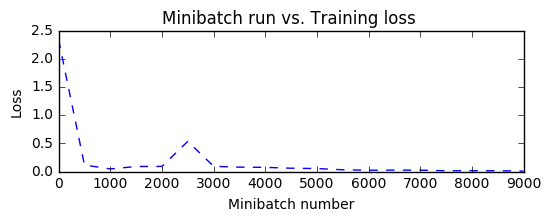

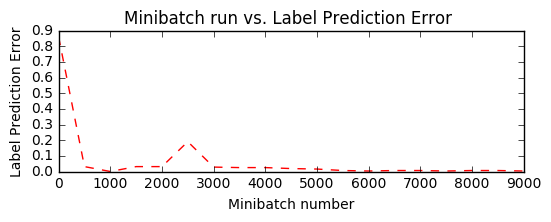

In [17]:
#Compute the moving average loss to smooth out the noise in SGD    

plotdata["avgloss"] = moving_average(plotdata["loss"])
plotdata["avgerror"] = moving_average(plotdata["error"])

#Plot the training loss and the training error
import matplotlib.pyplot as plt

plt.figure(1)
plt.subplot(211)
plt.plot(plotdata["batchsize"], plotdata["avgloss"], 'b--')
plt.xlabel('Minibatch number')
plt.ylabel('Loss')
plt.title('Minibatch run vs. Training loss ')

plt.show()

plt.subplot(212)
plt.plot(plotdata["batchsize"], plotdata["avgerror"], 'r--')
plt.xlabel('Minibatch number')
plt.ylabel('Label Prediction Error')
plt.title('Minibatch run vs. Label Prediction Error ')
plt.show()

## Evaluation / Testing 

Now that we have trained the network, let us evaluate the trained network on the test data. This is done using `trainer.test_minibatch`.

In [18]:
# Ensure the training data is read and available for this tutorial
test_file = "data/MNIST/Test-28x28_cntk_text.txt"

if os.path.isfile(test_file):
    path = test_file
else:
    print("Please generate the data by completing CNTK 103 Part A")

feature_stream_name = 'features'
labels_stream_name = 'labels'

test_mb_source = text_format_minibatch_source(path, [
    StreamConfiguration(feature_stream_name, input_dim),
    StreamConfiguration(labels_stream_name, num_output_classes)])
features_si = mb_source[feature_stream_name]
labels_si = mb_source[labels_stream_name]

print("Test data from file {0} successfully read".format(path))


Test data from file data/MNIST/Test-28x28_cntk_text.txt successfully read


In [19]:
# Test data for trained model
test_minibatch_size = 512
num_samples = 10000
num_minibatches_to_test = num_samples / test_minibatch_size
test_result = 0.0
for i in range(0, int(num_minibatches_to_test)):
    mb = test_mb_source.next_minibatch(test_minibatch_size)

    # Specify the mapping of input variables in the model to actual
    # minibatch data to be tested with
    arguments = {input: mb[features_si],
                 label: mb[labels_si]}
    eval_error = trainer.test_minibatch(arguments)
    test_result = test_result + eval_error

# Average of evaluation errors of all test minibatches
print("Average test error: {0:.2f}%".format(test_result*100 / num_minibatches_to_test))

Average test error: 1.74%


Note, this error is very comparable to our training error indicating that our model has good "out of sample" error a.k.a generalization error. This implies that our model can very effectively deal with previously unseen observations (during the training process). This is key to avoid the phenomenon of overfitting. 

We have so far been dealing with aggregate measures of error. Lets now get the probabilities associated with individual data points. For each observation, the `eval` function returns the probability distribution across all the classes. The classifer is trained to recognize digits, hence has 10 classes. First let us route the network output through a `softmax` function. This maps the aggregated activations across the netowrk to probabilities across the 10 classes.

In [20]:
out = softmax(z)

Lets a small minibatch sample from the test data.

In [21]:
mb = test_mb_source.next_minibatch(test_minibatch_size)

predicted_label_prob =out.eval({input : mb[features_si]})

#orig_label=np.array(mb[labels_si].m_data.data().to_numpy())
orig_label = np.asarray(mb[labels_si].m_data)

In [22]:
#Find the index with the maximum value for both predicted as well as the ground truth
pred = [np.argmax(predicted_label_prob[i,:,:]) for i in range(0,predicted_label_prob.shape[0])]
gtlabel = [np.argmax(orig_label[i,:,:]) for i in range(0, orig_label.shape[0])]

In [23]:
print("Label    :", gtlabel[:25])
print("Predicted:", pred[:25])

Label    : [7, 9, 0, 1, 7, 9, 0, 0, 9, 2, 9, 3, 8, 5, 7, 8, 8, 0, 8, 4, 6, 8, 6, 2, 3]
Predicted: [7, 9, 0, 1, 7, 9, 0, 0, 9, 2, 9, 3, 8, 5, 7, 8, 8, 0, 8, 4, 6, 8, 6, 2, 3]


Lets visualize some of the results

Image Label:  8


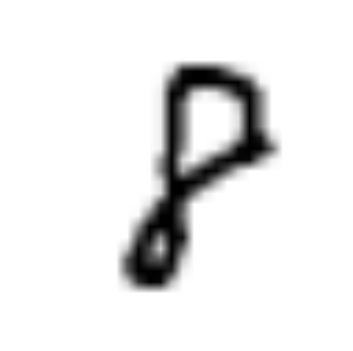

In [24]:
# Plot a random image
sample_number = 15
#img_data = mb[features_si].m_data.data().to_numpy()
img_data = mb[features_si].value
plt.imshow(img_data[sample_number,:,:].reshape(28,28), cmap="gray_r")
plt.axis('off')

img_gt, img_pred = gtlabel[sample_number], pred[sample_number]
print("Image Label: ", img_pred)

**Exploration Suggestion**
-  Try exploring how the classifier behaves with different parameters - suggest changing the `minibatch_size` parameter from 25 to say 64 or 128. What happens to the error rate? How does the error compare to the logistic regression classifier?
- Suggest trying to increase the number of sweeps
- Can you change the network to reduce the training error rate? When do you see *overfitting* happening?

#### Code link

If you want to try running the tutorial from python command prompt. Please run the [SimpleMNIST.py](https://github.com/Microsoft/CNTK/tree/v2.0.beta2.0/bindings/python/examples/MNIST) example.